In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
# Make sure to have the latest version of packages. In order to use latest environment, 
# choose "Always use latest environment" option in Notebook options

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq duckduckgo_search
    !pip install -Uqq fastai
    
# make sure you have python 3.10 and duckduckgo 3.9.5
import sys
print(sys.version)

import duckduckgo_search
print(duckduckgo_search.__version__)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
6.1.7


In [4]:
from itertools import islice
from duckduckgo_search import DDGS
from fastcore.all import *


def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    # DDGS().images return an interator containing all images found
    # we use islice to limit the number of results returned
    return L(islice(DDGS().images(term), max_images)).itemgot('image')

In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('superman comic photos', max_images=1)
urls[0]

Searching for 'superman comic photos'


'https://i.pinimg.com/originals/81/28/7b/81287b176108edb4e6f50083c056587b.jpg'

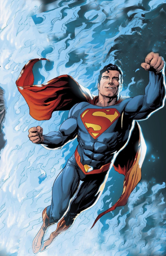

In [6]:
from fastdownload import download_url
dest = 'superman comic.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'bird photos'


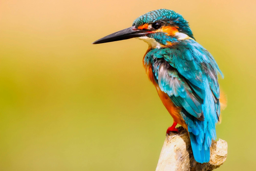

In [7]:
download_url(search_images('bird photos', max_images=1)[0], 'bird.jpg', show_progress=True)
Image.open('bird.jpg').to_thumb(256,256)

Searching for 'plane photos'


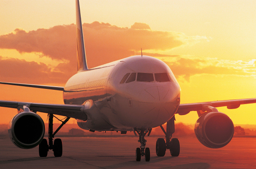

In [8]:
download_url(search_images('plane photos', max_images=1)[0], 'plane.jpg', show_progress=True)
Image.open('plane.jpg').to_thumb(256,256)

In [9]:
searches = 'superman','bird','plane'
path = Path('superman_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} flying photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} sky photo'))
    sleep(10)

Searching for 'superman photo'
Searching for 'superman flying photo'
Searching for 'superman sky photo'
Searching for 'bird photo'
Searching for 'bird flying photo'
Searching for 'bird sky photo'
Searching for 'plane photo'
Searching for 'plane flying photo'
Searching for 'plane sky photo'


In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


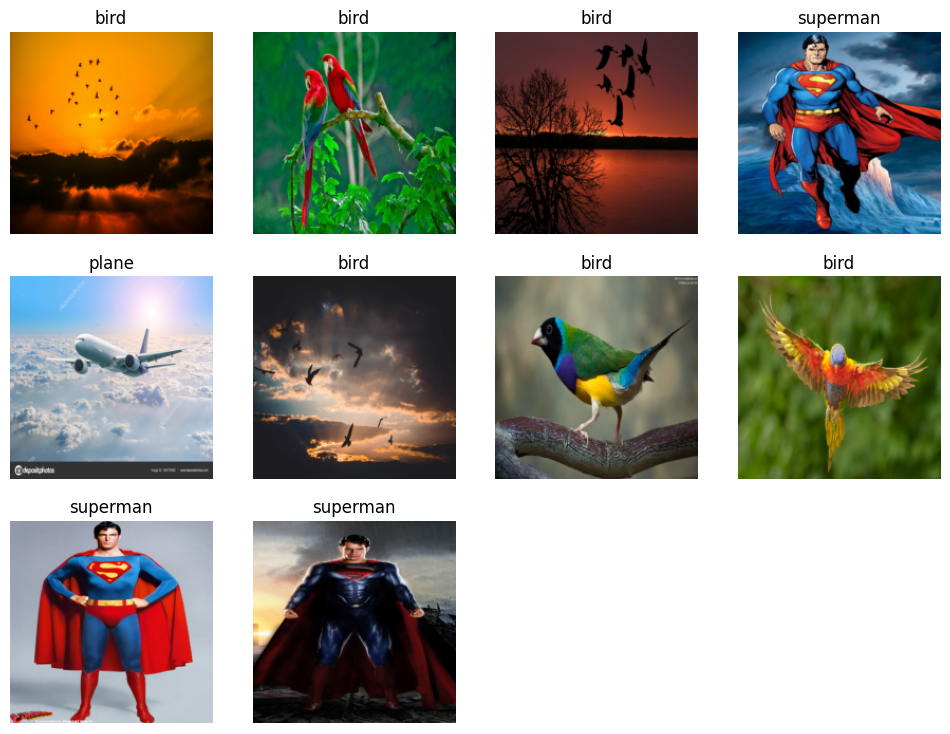

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=10)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.647264,0.422676,0.153846,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.260668,0.256195,0.096154,00:36
1,0.166585,0.128797,0.038462,00:36
2,0.115536,0.038975,0.019231,00:45


In [13]:
is_superman,_,probs = learn.predict(PILImage.create('superman comic.jpg'))
print(f"This is : {is_superman}.")
print(f"Probability Confidence: {probs[0]:.4f}")
print(f"Probability Confidence: {probs[1]:.4f}")
print(f"Probability Confidence: {probs[2]:.4f}")

This is : superman.
Probability Confidence: 0.0000
Probability Confidence: 0.0000
Probability Confidence: 1.0000
